# **`Facial Emotion Recognition `**

remark : sometimes we implement similar functions and inputs in different parts of the code, It was solely for functional reasons as we wanted to be able to execture different sections independently.
It is the 3dr model that is used in our web Application 
The web application script is in another file 

In [1]:
import dlib
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import cv2
from skimage.color import rgb2gray
from scipy import ndimage
from skimage import data
import matplotlib.cm as cm
from google.colab.patches import cv2_imshow
import torch
from keras import metrics
from keras.metrics import categorical_accuracy
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
import h5py
print('here')

here


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Description of the project
Our objective is to succeed to predict which emotion a person on a picture is feeling between hapiness, surprise, fear, sadness, anger, disgust and neutral emotion. This project is included on a bigger project which is to track drivers' emotion on the road.

# Data

Here is the data we will use , 

It is the FER2013 open source Dataset (Facial Emotion Recognition)
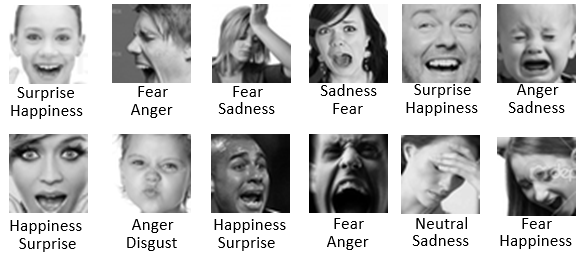 


In [ ]:
#df = pd.read_csv(r'/content/fer2013.csv')
df = pd.read_csv(r'/content/drive/MyDrive/Deep_learning_emotions/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Our labels are :

In [ ]:
#dictionnary of labels
labelDic = {}
labelDic[0] = 'Anger'
labelDic[1] = 'Disgust'
labelDic[2] = 'Fear'
labelDic[3] = 'Happy'
labelDic[4] = 'Sad'
labelDic[5] = 'Suprise'
labelDic[6] = 'Neutral'
labelDic[-1] = 'Unknown'

# Data visualization
First, some data visualization.

In [ ]:
def fromPxlToImage(num_img):
    #transform the array of pixels into an image
    pixels = df.iloc[num_img,1]
    pic = pixels.split(" ")
    map_object = map(int,pic)
    picList = list(map_object)
    image = np.array(picList).reshape(48,48)
    return image
    

def printImage(num_img):
    #it will print the image and its emotion
    pix = df.iloc[num_img,1]
    label = df.iloc[num_img,0]
    emotion = labelDic[label]
    print(label,emotion)
    image = fromPxlToImage(num_img)
    plt.imshow(image, cmap="gray")


6 Neutral


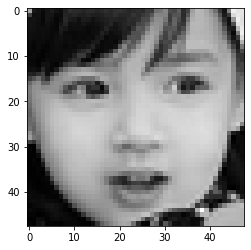

In [ ]:
printImage(3098)

# Landmarks
The first objective of our project is to detect landmarks on the pictures. It will be easier to work with landmarks as input in our neural networks.

To do so, we use pre-trained facial landmark detector inside the dlib library which is used to estimate the location of 68 (x, y)-coordinates that map to facial structures on the face.
We use Adrian Rosebrock's code from his blog and adapt it to our situation.

Link to the blog :
https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/


In [ ]:
def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [ ]:
# initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
#predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
predictor = dlib.shape_predictor('/content/drive/MyDrive/Deep_learning_emotions/shape_predictor_68_face_landmarks.dat')

In [ ]:
#this function detect the face, landmarks, and modify the image to put landmarks and bounding box in it

def imgToLandmarksandImg(num_img):
  shape = None
  pixarray = fromPxlToImage(num_img)
  #temporary save the image to use it
  cv2.imwrite('/content/drive/MyDrive/Deep_learning_emotions/temp_img.jpg', pixarray)
  image = cv2.imread('/content/drive/MyDrive/Deep_learning_emotions/temp_img.jpg')
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	# detect faces in the grayscale image
  rects = detector(gray, 1)
	# loop over the face detections
  for (i, rect) in enumerate(rects):
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
	  shape = predictor(gray, rect)
	  shape = shape_to_np(shape)
	  # convert dlib's rectangle to a OpenCV-style bounding box
		# [i.e., (x, y, w, h)], then draw the face bounding box
	  (x, y, w, h) = rect_to_bb(rect)
	  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
		# show the face number
	  cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
	  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
		# loop over the (x, y)-coordinates for the facial landmarks
		# and draw them on the image
	  for (x, y) in shape:
		  cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
  return image, shape

def imgToLandmarks(num_img):
  shape=None
  pixarray = fromPxlToImage(num_img)
  #temporary save the image to use it
  cv2.imwrite('/content/drive/MyDrive/Deep_learning_emotions/temp_img.jpg', pixarray)
  image = cv2.imread('/content/drive/MyDrive/Deep_learning_emotions/temp_img.jpg')
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	# detect faces in the grayscale image
  rects = detector(gray, 1)
	# loop over the face detections
  for (i, rect) in enumerate(rects):
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
  return shape

In [ ]:
#this function prints the image after the process of landmarks
def printImgWithLandmarks(num_img):
  image, shape = imgToLandmarksandImg(num_img)
  # show the output image with the face detections + facial landmarks
  #since google collab can use cv2.imshow() I use google collab's imshow
  cv2_imshow(image)
  cv2.waitKey()

Here is an example of the result of this process. In our case pictures are already face-centered but we might need the bounding boxe to detect the face in the future.

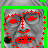

In [ ]:
printImgWithLandmarks(1)

In [ ]:
print("These are the 68 landmarks :")
landmarks = imgToLandmarks(1)
print(landmarks)

These are the 68 landmarks :
[[ 4 24]
 [ 5 29]
 [ 7 33]
 [ 9 37]
 [11 41]
 [13 45]
 [17 47]
 [21 49]
 [26 49]
 [32 48]
 [37 46]
 [40 43]
 [42 38]
 [43 33]
 [44 28]
 [44 22]
 [44 17]
 [ 6 18]
 [ 8 16]
 [12 15]
 [15 14]
 [19 15]
 [23 13]
 [27 12]
 [31 11]
 [35 12]
 [38 13]
 [22 18]
 [22 21]
 [22 24]
 [22 27]
 [19 31]
 [21 32]
 [23 32]
 [26 31]
 [28 30]
 [10 21]
 [12 20]
 [14 20]
 [17 21]
 [14 21]
 [12 22]
 [28 19]
 [30 17]
 [32 17]
 [35 18]
 [33 19]
 [30 19]
 [16 40]
 [18 38]
 [21 37]
 [24 37]
 [26 36]
 [29 37]
 [33 38]
 [30 41]
 [27 42]
 [24 42]
 [22 42]
 [19 42]
 [17 40]
 [21 38]
 [24 38]
 [26 38]
 [32 38]
 [26 40]
 [24 40]
 [21 40]]


We now have the possibility to get the landmark array for one image with the **imgToLandmarks function** .
Now we want to have this data available directly in the CSV file, as a new column of data.


In [ ]:
newDataframe = df.copy()

#function to test
def fromPxlToImagePIX(pixels):
    pic = pixels.split(" ")
    map_object = map(int,pic)
    picList = list(map_object)
    image = np.array(picList).reshape(48,48)
    return image

#we add another column to the dataframe with directly the pixel matrix (easier to use)
newDataframe['image'] = newDataframe['pixels'].apply(fromPxlToImagePIX)

#we need this to be able to access the number of the photo easily
newDataframe['nb_img'] = 1

nb_rows = len(newDataframe.index)
for i in range(nb_rows):
  newDataframe.loc[newDataframe.index[i], 'nb_img'] = i
newDataframe.head(5)

,emotion,pixels,Usage,image,nb_img
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",0
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",1
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",2
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...",3
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",4


In [ ]:
newDataframe['landmarks'] = newDataframe['nb_img'].apply(imgToLandmarks)


print(newDataframe.head(5))


   emotion  ...                                          landmarks
0        0  ...  [[-2, 15], [-2, 22], [-2, 28], [-1, 35], [1, 4...
1        0  ...  [[4, 24], [5, 29], [7, 33], [9, 37], [11, 41],...
2        2  ...  [[6, 13], [5, 17], [4, 22], [3, 28], [2, 33], ...
3        4  ...                                               None
4        6  ...  [[2, 20], [3, 25], [4, 30], [5, 35], [7, 40], ...

[5 rows x 6 columns]


Now we have a new csv with landmarks. But we can see that for some rows, it was not possible to extract landmarks.

# Data Cleaning

We want to delete rows for which it was not possible to extract landmarks.

Indeed, in some pictures of the FER2013 dataset, actors/models have their hands in from of their mouth of in from of their face so It makes landmark extraction impossible.

In [ ]:
newDataframe.isnull().sum()

emotion          0
pixels           0
Usage            0
image            0
nb_img           0
landmarks    10932
dtype: int64

Nearly 11000 images have null landmarks. Let's check we have enough data for each emotion to train our model.

In [ ]:
newDataframe = newDataframe.dropna()
print(newDataframe.head(10))

    emotion  ...                                          landmarks
0         0  ...  [[-2, 15], [-2, 22], [-2, 28], [-1, 35], [1, 4...
1         0  ...  [[4, 24], [5, 29], [7, 33], [9, 37], [11, 41],...
2         2  ...  [[6, 13], [5, 17], [4, 22], [3, 28], [2, 33], ...
4         6  ...  [[2, 20], [3, 25], [4, 30], [5, 35], [7, 40], ...
5         2  ...  [[3, 23], [4, 28], [4, 33], [5, 38], [7, 43], ...
7         3  ...  [[10, 23], [10, 26], [10, 29], [11, 32], [13, ...
8         3  ...  [[4, 19], [5, 24], [6, 29], [8, 34], [10, 38],...
9         2  ...  [[4, 20], [4, 26], [5, 31], [6, 37], [9, 41], ...
10        0  ...  [[2, 18], [2, 24], [2, 30], [3, 36], [4, 41], ...
11        6  ...  [[4, 23], [5, 28], [7, 32], [9, 37], [11, 41],...

[10 rows x 6 columns]


In [ ]:
newDataframe['emotion'].value_counts()

3    6986
6    4662
0    3399
4    3329
2    3183
5    2969
1     427
Name: emotion, dtype: int64

We see that we only have 427 images left for "disgust". We will see if it is enough to train our model. If not, it is not very important because disgust is not so important for our driver project.

We now want to binarize our images thanks to landmarks' information. Sometimes landmarks are out of bonds, we chose to move them so that they will fit in the boxe. Plus we decided to drop the first landmarks that contain the information of the face shape detection. We have gathered enough evidence that keeping them would form a disdvatage, plus they do not provide enough information for our network: face shapes in humans are very different depending on the individual, and it is not reliable because its form varies greatly depending on the angle of the face on the photo. 

In [ ]:
def create_image(liste):
    img = np.zeros((48,48),dtype = 'uint8')
    liste = liste[17:]
    for point in liste:
        x = point[0]
        y = point[1]
        if x < 0:
          x = 0
        if x > 47 :
          x= 47
        if y >47 :
          y = 47
        if y <0:
          y=0
        img[y][x] = 1
    #plt.imshow(img, cpam ="gray")
    imList = img.reshape(48*48)
    #print(imList)
    return imList
    

In [ ]:
newDataframe['binary_img'] = newDataframe['landmarks'].apply(create_image)

In [ ]:
newDataframe.head()

,emotion,pixels,Usage,image,nb_img,landmarks,binary_img
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",0,"[[-2, 15], [-2, 22], [-2, 28], [-1, 35], [1, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",1,"[[4, 24], [5, 29], [7, 33], [9, 37], [11, 41],...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",2,"[[6, 13], [5, 17], [4, 22], [3, 28], [2, 33], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",4,"[[2, 20], [3, 25], [4, 30], [5, 35], [7, 40], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training,"[[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151,...",5,"[[3, 23], [4, 28], [4, 33], [5, 38], [7, 43], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


We save this new dataframe.

In [ ]:
newDataframe.to_csv(r'/content/drive/MyDrive/Deep_learning_emotions/newFer2013.csv', index = False)

In [ ]:
newDataframe.to_pickle('/content/drive/MyDrive/Deep_learning_emotions/pickleFer2013.pkl')

We are ready to begin to code the neural network.

# Preparing training and test datasets
First we want to create two distinct dataframes, one for training and one for testing.

In [4]:
#newdf = pd.read_pickle('/content/drive/MyDrive/Deep_learning_emotions/pickleFer2013.pkl')
newdf = pd.read_pickle('/content/drive/MyDrive/pickleFer2013.pkl')
newdf['emotion'].value_counts()

3    6986
6    4662
0    3399
4    3329
2    3183
5    2969
1     427
Name: emotion, dtype: int64

In [5]:
newdf.head()

,emotion,pixels,Usage,image,nb_img,landmarks,binary_img
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",0,"[[-2, 15], [-2, 22], [-2, 28], [-1, 35], [1, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",1,"[[4, 24], [5, 29], [7, 33], [9, 37], [11, 41],...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",2,"[[6, 13], [5, 17], [4, 22], [3, 28], [2, 33], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",4,"[[2, 20], [3, 25], [4, 30], [5, 35], [7, 40], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training,"[[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151,...",5,"[[3, 23], [4, 28], [4, 33], [5, 38], [7, 43], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


First we'll do a little more data cleaning here.\n

(The csv files are very voluminous to transfert and change everytime to we do that here)

After the first tests of the CNN, we dicided that the disgust emotion is not worth keeping : it has to little training samples and doesn't serve our project. The accuracy in this project is quite low (around 50% accuracy for now) but with one less class to classify, we can hope that the accuracy will go up

Plus we will be cleaning unknown emotions from this dataframe.

Now, the emotion data accross each category is much more equally distributed (though we can argue that there is more than double the amount of happy faces than suprised faces. 


In [5]:
newdf = newdf[newdf.emotion != 1] #we drop the data from the disgust rows 
newdf = newdf[newdf.emotion != -1] #we drop the unknown labels if they are 
newdf['emotion'].value_counts()

3    6986
6    4662
0    3399
4    3329
2    3183
5    2969
Name: emotion, dtype: int64

In [6]:
#we are going to replace neutral 6  by neutral 1, so that we have the labels between 0 and 5
#newdf[newdf.emotion == 6] = 1 
newdf['emotion'].replace({6:1},inplace = True)
newdf['emotion'].value_counts()

3    6986
1    4662
0    3399
4    3329
2    3183
5    2969
Name: emotion, dtype: int64

In [ ]:
training = newdf.loc[newdf["Usage"] == "Training"]
public_test = newdf.loc[newdf["Usage"] == "PublicTest"]
private_test = newdf.loc[newdf["Usage"] == "PrivateTest"]
test = pd.concat([public_test, private_test])

In [ ]:
print("training shape = ", training.shape)
print(training['emotion'].value_counts().count())
training


training shape =  (19652, 7)
6


,emotion,pixels,Usage,image,nb_img,landmarks,binary_img
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",0,"[[-2, 15], [-2, 22], [-2, 28], [-1, 35], [1, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",1,"[[4, 24], [5, 29], [7, 33], [9, 37], [11, 41],...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",2,"[[6, 13], [5, 17], [4, 22], [3, 28], [2, 33], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",4,"[[2, 20], [3, 25], [4, 30], [5, 35], [7, 40], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training,"[[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151,...",5,"[[3, 23], [4, 28], [4, 33], [5, 38], [7, 43], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
28702,0,196 194 188 177 156 124 81 60 65 64 84 119 114...,Training,"[[196, 194, 188, 177, 156, 124, 81, 60, 65, 64...",28702,"[[2, 26], [3, 30], [4, 35], [6, 40], [8, 44], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28703,5,255 255 255 255 255 255 255 203 145 147 143 14...,Training,"[[255, 255, 255, 255, 255, 255, 255, 203, 145,...",28703,"[[7, 19], [7, 24], [8, 28], [10, 33], [11, 38]...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,Training,"[[84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, ...",28704,"[[8, 20], [8, 24], [9, 29], [10, 33], [11, 38]...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,Training,"[[222, 227, 203, 90, 86, 90, 84, 77, 94, 87, 9...",28707,"[[6, 21], [6, 26], [8, 32], [9, 37], [11, 42],...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
print("test shape = ", test.shape)

test shape =  (4876, 7)


In [ ]:
print("emotions training\n", training["emotion"].value_counts())

emotions training
 3    5605
1    3731
0    2757
4    2664
2    2537
5    2358
Name: emotion, dtype: int64


In [ ]:
print("emotions public test\n", test["emotion"].value_counts())

emotions public test
 3    1381
1     931
4     665
2     646
0     642
5     611
Name: emotion, dtype: int64


Now we split into inputs and labels.

One hot encoding, to categorical

In [ ]:
labels_train = training["emotion"]
labels_train = to_categorical(labels_train)
labels_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
labels_test = test["emotion"]
labels_test = to_categorical(labels_test)

In [ ]:
binary_img_train = training["binary_img"].tolist()

binary = []
for elem in binary_img_train :
  binary.append(elem.tolist())

binary_img_train = binary
binary_img_train = np.uint8(binary_img_train)
binary_img_train = binary_img_train.reshape((19652, 48, 48, 1))

In [ ]:
binary_img_test = test["binary_img"].tolist()

binary = []
for elem in binary_img_test :
  binary.append(elem.tolist())

binary_img_test = binary
binary_img_test = np.uint8(binary_img_test)
binary_img_test = binary_img_test.reshape((4876, 48, 48, 1))

# Neural network with landmarks

Now we are ready to build our neural network.

There is truly a significant number of different architectures possible. We tried for this first architecture to get inspired by an architecture that was present in a research paper : 

First lets limit the number of layers, as an too important number of layers can decrease the accuracy of the algorithm (the learning capacities)

One of the inspiration for the following architecture was this paper : 

https://arxiv.org/ftp/arxiv/papers/1706/1706.01509.pdf

In [ ]:
model_1 = models.Sequential()

#10 is the number of filters that are generated by this layer
model_1.add(layers.Conv2D(10, (5, 5), activation='relu', input_shape=(48,48,1)))
model_1.add(layers.AveragePooling2D(pool_size=(2,2), strides=(2, 2))) #pooling size of (2,2) is what is mostly done in the literature

model_1.add(layers.Conv2D(10, (5, 5), activation='relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model_1.add(layers.Conv2D(10, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model_1.add(layers.Flatten())

model_1.add(layers.Dense(256, activation='relu'))
#dropout is here to desactivate some neurons in order to increase learning capabilities
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dropout(0.5))

#the output is softmax : probabilities on each class 
model_1.add(layers.Dense(6, activation='softmax'))

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 10)        260       
_________________________________________________________________
average_pooling2d (AveragePo (None, 22, 22, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 10)        2510      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 10)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 10)          910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 90)                0

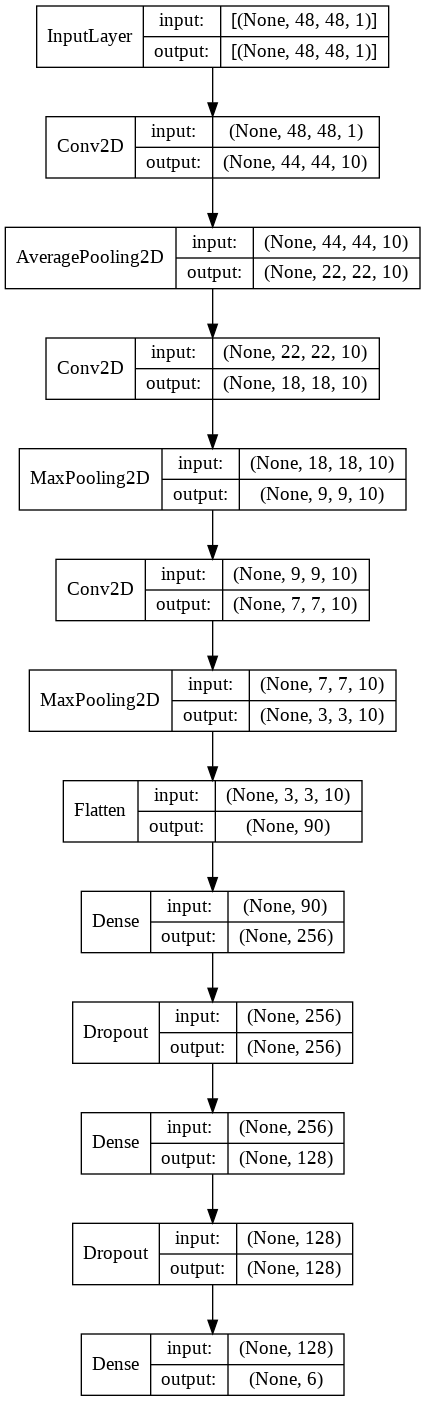

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes=True, show_layer_names=False)

In [ ]:
model_1.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

tr = model_1.fit(binary_img_train, labels_train, batch_size = 500, epochs = 150,validation_data = (binary_img_test, labels_test))

Epoch 1/150
40/40 [==============================] - 25s 614ms/step - loss: 1.1917 - accuracy: 0.5370 - val_loss: 1.2542 - val_accuracy: 0.5183
Epoch 2/150
40/40 [==============================] - 24s 606ms/step - loss: 1.1725 - accuracy: 0.5492 - val_loss: 1.2623 - val_accuracy: 0.5142
Epoch 3/150
40/40 [==============================] - 24s 603ms/step - loss: 1.1745 - accuracy: 0.5476 - val_loss: 1.2631 - val_accuracy: 0.5174
Epoch 4/150
40/40 [==============================] - 24s 602ms/step - loss: 1.1597 - accuracy: 0.5481 - val_loss: 1.2554 - val_accuracy: 0.5180
Epoch 5/150
40/40 [==============================] - 24s 603ms/step - loss: 1.1684 - accuracy: 0.5497 - val_loss: 1.2542 - val_accuracy: 0.5193
Epoch 6/150
40/40 [==============================] - 24s 609ms/step - loss: 1.1455 - accuracy: 0.5619 - val_loss: 1.2626 - val_accuracy: 0.5178
Epoch 7/150
40/40 [==============================] - 25s 632ms/step - loss: 1.1614 - accuracy: 0.5513 - val_loss: 1.2647 - val_accuracy:

We save the network so we can use it later.

In [ ]:
model_1.save('/content/drive/MyDrive/test_2_1501_150epoch.h5')

NameError: ignored

In [ ]:
from keras.models import load_model
model_1 = load_model('/content/drive/MyDrive/test_2_1501_150epoch.h5')

### Confusion Matrix ,Classification report and model results

In [ ]:
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from keras import backend as K

In [ ]:
Y_pred = model_1.predict_classes(binary_img_test, batch_size=500,verbose = 0)
print(Y_pred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1 2 3 ... 5 5 0]


In [ ]:
scores = model_1.evaluate(binary_img_test,labels_test,verbose = 0)
print("Accuracy:%.2f%%"%(scores[1]*100))

Accuracy:51.07%


Some plots to visualise results.

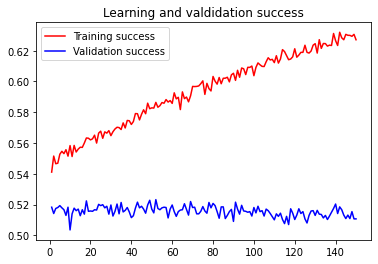

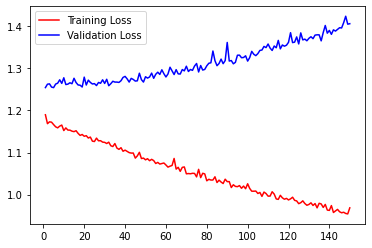

In [ ]:
acc = tr.history["accuracy"]
val_acc = tr.history["val_accuracy"]
loss = tr.history["loss"]
val_loss = tr.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "r", label = "Training success")
plt.plot(epochs, val_acc, "b", label = "Validation success")
plt.title("Learning and valdidation success")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "r", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.legend()


plt.show()



There is an evident case of **overfitting**
indeed, the accuracy on the training data is up to 63% but the accuracy on the test data is always low at 51%


5 Suprise
[0 0 0 ... 0 0 0]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


the emotion predicted by our Neural Network is
Suprise


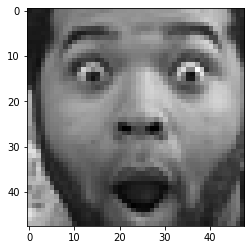

In [ ]:
#we are trying to test our model on an image of the test dataset 
import random 
random.seed(17)

mapper = {
    0: "Anger",
    1: "Neutral",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Suprise"
    }

def printPicture(num_img):
    pix = test.iloc[num_img,1]
    label = test.iloc[num_img,0]
    emotion = mapper[label]
    print(label, emotion)
    pic = pix.split(" ")
    map_object = map(int,pic)
    picList = list(map_object)
    image = np.array(picList).reshape(48,48)
    plt.imshow(image, cmap="gray")

#we are going to take a random image between 20000 and 24000
rand = random.randint(0,4875)

#lets print this picture 
printPicture(rand)

#now lets try to print the prediction of our model for this particular picture
input = np.array(newdf.iloc[rand,-1]) #gets the binary data for our input to the prediction model
print(input)

predictions = model_1.predict_classes(binary_img_test,verbose = 0)

max_index = predictions[rand]#the prediction of our model 
max_label = mapper[max_index]

print('the emotion predicted by our Neural Network is')
print(max_label)


In [ ]:
#this is the real output of the prediction: softmax gives a distribution of probabilities, of which the sum is equal to 1

predictions = model_1.predict(binary_img_test,verbose = 0)
#predictions
input = np.reshape(input,((1,48,48,1)))
print(input.shape)
pred = model_1.predict(input,verbose = 0)
print(pred)

(1, 48, 48, 1)
[[0.2595065  0.04395975 0.07732649 0.4940042  0.0846265  0.0405766 ]]


<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1 2 3 ... 5 1 0]


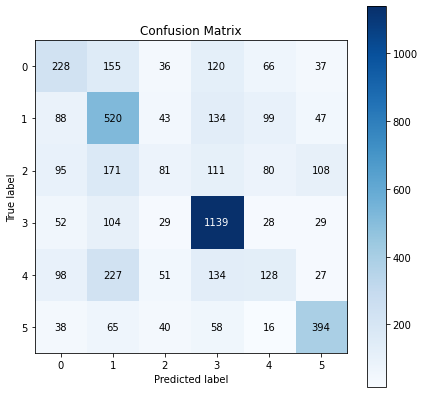

In [ ]:
#!pip install scikit-plot
import scikitplot
from scikitplot.metrics import plot_confusion_matrix, plot_roc

X_valid = binary_img_test
print(type(X_valid))
Y_cnn_valid = model_1.predict_classes(X_valid)
print(Y_cnn_valid)

scikitplot.metrics.plot_confusion_matrix(np.argmax(labels_test, axis=1), Y_cnn_valid, figsize=(7,7))
#save("confusion_matrix_dcnn.png")


# Neural network Transfert Learning with VGG16 face (Not complete)

https://www.kaggle.com/rkuo2000/fer2013-cnn

As we saw previoulsy, regular CNN model doesn't have great accuracy (51%) at best on training data and 63% on training data 

One way to better the accuracy of a neural network is to use pretrained weights from another similar problem, it is transfert learning 

We will try to implement this method bellow with the hope to better our result 


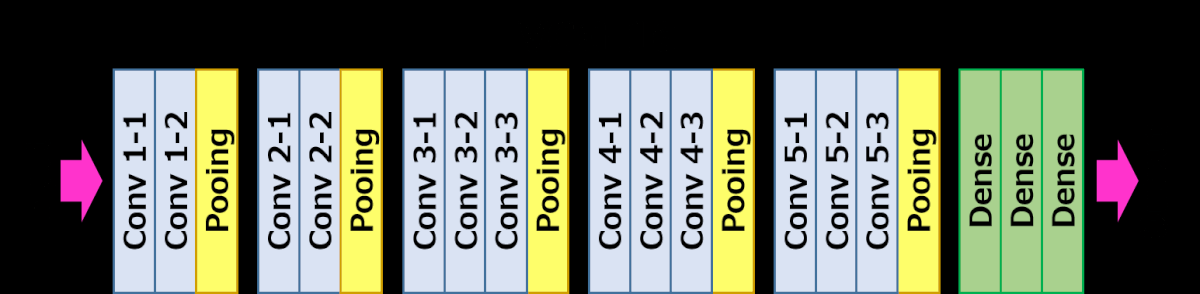


In [7]:
#first we need to reprocess aa little bit the inputs, as VGG16 takes in an image with 3 channels and not 1 as previously

df2 = newdf.copy()

def finalform(binary_image):
  a = np.array(binary_image)
  a = np.reshape(binary_image,(48,48))
  stacked_image = np.stack((a,)*3,axis = -1)
  return stacked_image

df2['final'] = df2['binary_img'].apply(finalform)

df2.head()

,emotion,pixels,Usage,image,nb_img,landmarks,binary_img,final
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",0,"[[-2, 15], [-2, 22], [-2, 28], [-1, 35], [1, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",1,"[[4, 24], [5, 29], [7, 33], [9, 37], [11, 41],...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",2,"[[6, 13], [5, 17], [4, 22], [3, 28], [2, 33], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,1,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",4,"[[2, 20], [3, 25], [4, 30], [5, 35], [7, 40], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training,"[[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151,...",5,"[[3, 23], [4, 28], [4, 33], [5, 38], [7, 43], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [8]:
#inputs

training2 = df2.loc[df2["Usage"] == "Training"]
public_test2 = df2.loc[df2["Usage"] == "PublicTest"]
private_test2 = df2.loc[df2["Usage"] == "PrivateTest"]
test2 = pd.concat([public_test2, private_test2])

#one hot encoding
labels_train2 = training2["emotion"]
labels_train2 = to_categorical(labels_train2)

labels_test2 = test2["emotion"]
labels_test2 = to_categorical(labels_test2)

#inputs
binary_img_train2 = training2["final"].tolist()
binarybis = []
for elem in binary_img_train2 :
  binarybis.append(elem.tolist())
binary_img_train2 = binarybis
binary_img_train2 = np.uint8(binary_img_train2)
binary_img_train2 = binary_img_train2.reshape((19652, 48, 48, 3))


binary_img_test2 = test2["final"].tolist()
binarybisbis = []
for elem in binary_img_test2 :
  binarybisbis.append(elem.tolist())

binary_img_test2 = binarybisbis
binary_img_test2 = np.uint8(binary_img_test2)
binary_img_test2 = binary_img_test2.reshape((4876, 48, 48, 3))


Pretrained model already in keras library

In [2]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adamax
vgg16 = VGG16(include_top=False, input_shape=(48,48,3), weights='imagenet') #we don't include the top 2 Fc layers
vgg16.trainable = False               # clearly prescribe that we do NOT overload the network.
                                          # Weights VGG16 in the process of learning will remain unchanged!

vgg16.summary()                       # pay attention to the number of trained and untrained parameters


58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

In [14]:
# add layers to VGG16:
model_2 = models.Sequential()
model_2.add(vgg16)
model_2.add(layers.Flatten())

#Now just copy the first model?
model_2.add(layers.Dense(256, activation='relu'))
#dropout is here to desactivate some neurons in order to increase learning capabilities
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(256, activation='relu'))
#dropout is here to desactivate some neurons in order to increase learning capabilities
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dropout(0.5))

#the output is softmax : probabilities on each class 
model_2.add(layers.Dense(6, activation='softmax'))


In [15]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [17]:
model_2.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

tr2 = model_2.fit(binary_img_train2, labels_train2, batch_size = 500, epochs = 7,validation_data = (binary_img_test2, labels_test2))

Epoch 1/7
40/40 [==============================] - 561s 14s/step - loss: 1.7412 - accuracy: 0.2872 - val_loss: 1.7253 - val_accuracy: 0.2832
Epoch 2/7
40/40 [==============================] - 560s 14s/step - loss: 1.7180 - accuracy: 0.2827 - val_loss: 1.6504 - val_accuracy: 0.2832
Epoch 3/7
40/40 [==============================] - 559s 14s/step - loss: 1.6563 - accuracy: 0.2957 - val_loss: 1.6061 - val_accuracy: 0.3288
Epoch 4/7
40/40 [==============================] - 560s 14s/step - loss: 1.6344 - accuracy: 0.3330 - val_loss: 1.6111 - val_accuracy: 0.4055
Epoch 5/7
40/40 [==============================] - 562s 14s/step - loss: 1.6127 - accuracy: 0.3622 - val_loss: 1.5149 - val_accuracy: 0.4104
Epoch 6/7
40/40 [==============================] - 559s 14s/step - loss: 1.5678 - accuracy: 0.3932 - val_loss: 1.4837 - val_accuracy: 0.4130
Epoch 7/7
40/40 [==============================] - 561s 14s/step - loss: 1.5613 - accuracy: 0.3882 - val_loss: 1.4695 - val_accuracy: 0.4139


In [18]:
model_2.save('/content/drive/MyDrive/test_2_1701_7epoch.h5')

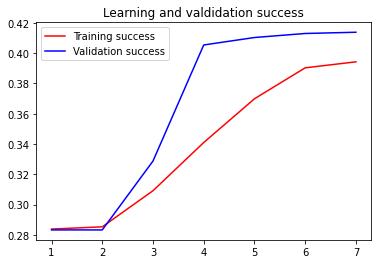

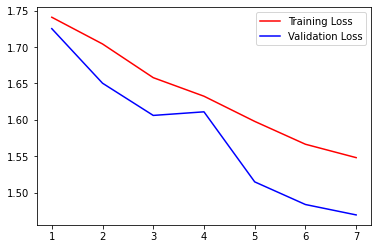

In [19]:
acc = tr2.history["accuracy"]
val_acc = tr2.history["val_accuracy"]
loss = tr2.history["loss"]
val_loss = tr2.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "r", label = "Training success")
plt.plot(epochs, val_acc, "b", label = "Validation success")
plt.title("Learning and valdidation success")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "r", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.legend()


plt.show()

<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[3 1 1 ... 3 3 5]
{0: 'Anger', 1: 'Neutral', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise'}


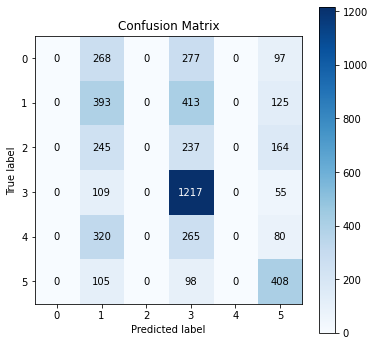

In [22]:
X_valid2 = binary_img_test2
print(type(X_valid2))
Y_cnn_valid2 = model_2.predict_classes(X_valid2)
print(Y_cnn_valid2)

!pip install scikit-plot
import scikitplot.metrics
from scikitplot.metrics import plot_confusion_matrix, plot_roc

print({0:'Anger',1:'Neutral',2:'Fear',3:'Happy',4:'Sad',5:'Surprise'})
scikitplot.metrics.plot_confusion_matrix(np.argmax(labels_test2, axis=1), Y_cnn_valid2, figsize=(6,6))

We can see that this model does not perfom very well, the architure is not right 



---

# Third model, Different CNN architecture 


We wanted to try another CNN architecture, with more layers, change the input shape and change the first pooling to max pooling instead of average pooling because in input we do have a binary image and maxpooling seems more adequate.

This archtecture has much more neurons than the first one, we except longer time of processing but hopefully better results, if the neural network is able to get more sensible features from our images.

architecture inspired by
https://youtu.be/m0fWjP3yIEo


In [17]:
df3 = newdf.copy()

def inputShapeform(binary_image):
  a = np.array(binary_image)
  a = np.reshape(binary_image,(48,48,-1)) #-1 means any number suitable, as we want 3D images with 1 channel 
  return a

#df3['binary'] = df3['binary_img'].apply(inputShapeform)

#a = df3.iloc[50,-1]
#print(a[:,:,0])

df3.head()

,emotion,pixels,Usage,image,nb_img,landmarks,binary_img
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...",0,"[[-2, 15], [-2, 22], [-2, 28], [-1, 35], [1, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,...",1,"[[4, 24], [5, 29], [7, 33], [9, 37], [11, 41],...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,...",2,"[[6, 13], [5, 17], [4, 22], [3, 28], [2, 33], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...",4,"[[2, 20], [3, 25], [4, 30], [5, 35], [7, 40], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training,"[[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151,...",5,"[[3, 23], [4, 28], [4, 33], [5, 38], [7, 43], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
#inputs

training3 = df3.loc[df3["Usage"] == "Training"]
public_test3 = df3.loc[df3["Usage"] == "PublicTest"]
private_test3 = df3.loc[df3["Usage"] == "PrivateTest"]
test3 = pd.concat([public_test3, private_test3])

#one hot encoding
labels_train3 = training3["emotion"]
labels_train3 = to_categorical(labels_train3)

labels_test3 = test3["emotion"]
labels_test3 = to_categorical(labels_test3)

#inputs
binary_img_train3 = training3["binary_img"].tolist()
binarybis = []
for elem in binary_img_train3 :
  binarybis.append(elem.tolist())
binary_img_train3 = binarybis
binary_img_train3 = np.uint8(binary_img_train3)
binary_img_train3 = binary_img_train3.reshape((19652, 48, 48, 1))


binary_img_test3 = test3["binary_img"].tolist()
binarybisbis = []
for elem in binary_img_test3 :
  binarybisbis.append(elem.tolist())

binary_img_test3 = binarybisbis
binary_img_test3 = np.uint8(binary_img_test3)
binary_img_test3 = binary_img_test3.reshape((4876, 48, 48, 1))


In [21]:
##lets implement a new model
model_3 = models.Sequential()

#first convolutional layer
model_3.add(layers.Conv2D(64,kernel_size = (3,3),activation = 'relu',input_shape =(48,48,1)))
model_3.add(layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model_3.add(layers.MaxPooling2D(pool_size = (2,2),strides = (2,2))) #max pool seems a better idea than averagepool
model_3.add(layers.Dropout(0.5))

#second convolutional layer
model_3.add(layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model_3.add(layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model_3.add(layers.MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model_3.add(layers.Dropout(0.5))

#third convolutional layer
model_3.add(layers.Conv2D(128,kernel_size = (3,3),activation = 'relu'))
model_3.add(layers.Conv2D(128,kernel_size = (3,3),activation = 'relu'))
model_3.add(layers.MaxPooling2D(pool_size = (2,2),strides = (2,2)))

model_3.add(layers.Flatten())

#Fully connected layers
model_3.add(layers.Dense(1024,activation = 'relu'))
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(1024,activation = 'relu'))
model_3.add(layers.Dropout(0.2))

#last layer
model_3.add(layers.Dense(6,activation = 'softmax'))


In [22]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0

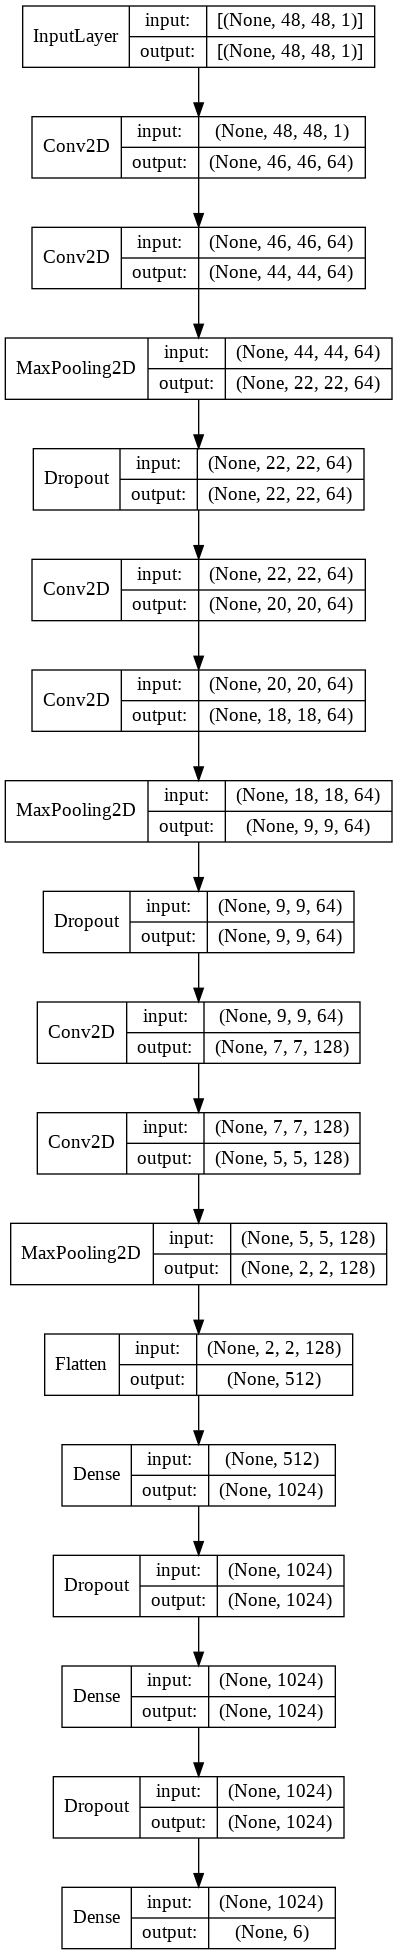

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, show_shapes=True, show_layer_names=False)

In [28]:
#compile the model and start training

model_3.compile(optimizer = 'Adam', loss = "categorical_crossentropy",metrics = ['accuracy'])
tr3 = model_3.fit(binary_img_train3, labels_train3, batch_size = 500, epochs = 50,validation_data = (binary_img_test3, labels_test3))

Epoch 1/50
40/40 [==============================] - 242s 6s/step - loss: 1.6372 - accuracy: 0.3564 - val_loss: 1.4635 - val_accuracy: 0.4270
Epoch 2/50
40/40 [==============================] - 242s 6s/step - loss: 1.4676 - accuracy: 0.4190 - val_loss: 1.4075 - val_accuracy: 0.4610
Epoch 3/50
40/40 [==============================] - 240s 6s/step - loss: 1.4108 - accuracy: 0.4529 - val_loss: 1.3837 - val_accuracy: 0.4676
Epoch 4/50
40/40 [==============================] - 242s 6s/step - loss: 1.3868 - accuracy: 0.4621 - val_loss: 1.3086 - val_accuracy: 0.4973
Epoch 5/50
40/40 [==============================] - 240s 6s/step - loss: 1.3421 - accuracy: 0.4747 - val_loss: 1.3144 - val_accuracy: 0.4949
Epoch 6/50
40/40 [==============================] - 242s 6s/step - loss: 1.3116 - accuracy: 0.5021 - val_loss: 1.3221 - val_accuracy: 0.4912
Epoch 7/50
40/40 [==============================] - 238s 6s/step - loss: 1.3119 - accuracy: 0.4966 - val_loss: 1.2750 - val_accuracy: 0.5098
Epoch 8/50
40

In [30]:
model_3.save('/content/drive/MyDrive/test_3_1601_50epoch.h5')
model_3.save_weights('/content/drive/MyDrive/test_3_1601_50epoch_weights.h5')

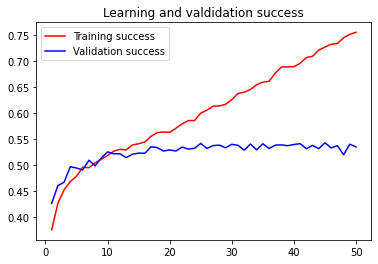

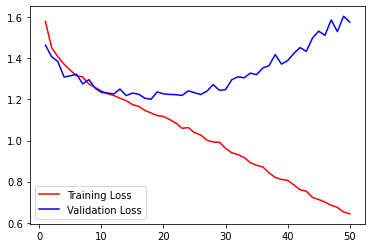

In [31]:
acc = tr3.history["accuracy"]
val_acc = tr3.history["val_accuracy"]
loss = tr3.history["loss"]
val_loss = tr3.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "r", label = "Training success")
plt.plot(epochs, val_acc, "b", label = "Validation success")
plt.title("Learning and valdidation success")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "r", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.legend()


plt.show()

In [39]:
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from keras import backend as K
#!pip install scikit-plot
import scikitplot.metrics
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [40]:
Y_pred3 = model_3.predict_classes(binary_img_test3, batch_size=500,verbose = 0)
print(Y_pred3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[2 1 3 ... 2 1 2]


In [41]:
scores = model_3.evaluate(binary_img_test3,labels_test3,verbose = 0)
print("Accuracy:%.2f%%"%(scores[1]*100))

Accuracy:53.53%


5 Suprise
[0 0 0 ... 0 0 0]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


the emotion predicted by our Neural Network is
Suprise


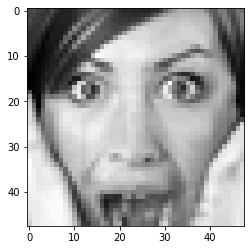

In [43]:
#we are trying to test our model on an image of the test dataset 
import random 
random.seed(48)

mapper = {
    0: "Anger",
    1: "Neutral",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Suprise"
    }

def printPicture(num_img):
    pix = test3.iloc[num_img,1]
    label = test3.iloc[num_img,0]
    emotion = mapper[label]
    print(label, emotion)
    pic = pix.split(" ")
    map_object = map(int,pic)
    picList = list(map_object)
    image = np.array(picList).reshape(48,48)
    plt.imshow(image, cmap="gray")

#we are going to take a random image between 20000 and 24000
rand = random.randint(0,4875)

#lets print this picture 
printPicture(rand)

#now lets try to print the prediction of our model for this particular picture
input = np.array(df3.iloc[rand,-1]) #gets the binary data for our input to the prediction model
print(input)

predictions = model_3.predict_classes(binary_img_test3,verbose = 0)

max_index = predictions[rand]#the prediction of our model 
max_label = mapper[max_index]

print('the emotion predicted by our Neural Network is')
print(max_label)

<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[2 1 3 ... 2 1 2]
{0: 'Anger', 1: 'Neutral', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise'}


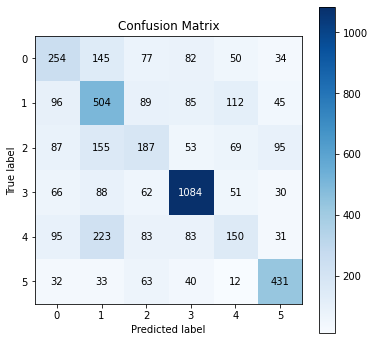

In [47]:
X_valid3 = binary_img_test3
print(type(X_valid3))
Y_cnn_valid3 = model_3.predict_classes(X_valid3)
print(Y_cnn_valid3)

print({0:'Anger',1:'Neutral',2:'Fear',3:'Happy',4:'Sad',5:'Surprise'})
scikitplot.metrics.plot_confusion_matrix(np.argmax(labels_test3, axis=1), Y_cnn_valid3, figsize=(6,6))


# Conclusions, remarks 

- we have implemented 3 different models, the one that we use for the web app is the third, it performs the best 

- TL has some potential but it was done last minute

- 	The real problem in Facial Emotion recognition is not the different models  but it is THE LACK OF A GOOD DATASET, with enough photos to tackle this issue. The dataset part is an issue that we can hope will be resolved in the upcoming years. And I believe that the results with CNN will be far better. But the dataset of facial emotions is very difficult to make, indeed, human emotions are very ambigous and sensitive to a lot of models (without technicals concerns for the image such as noise, lighting conditions, face shape and pose). Indeed see the following image. How good a dataset can really be ? Do humans have better than 55% accuracy ?

- state of the art does't perform much better with CNN on this dataset, I believe that this problem needs much more complex architecture. 



### Let's compare model 1 and 3

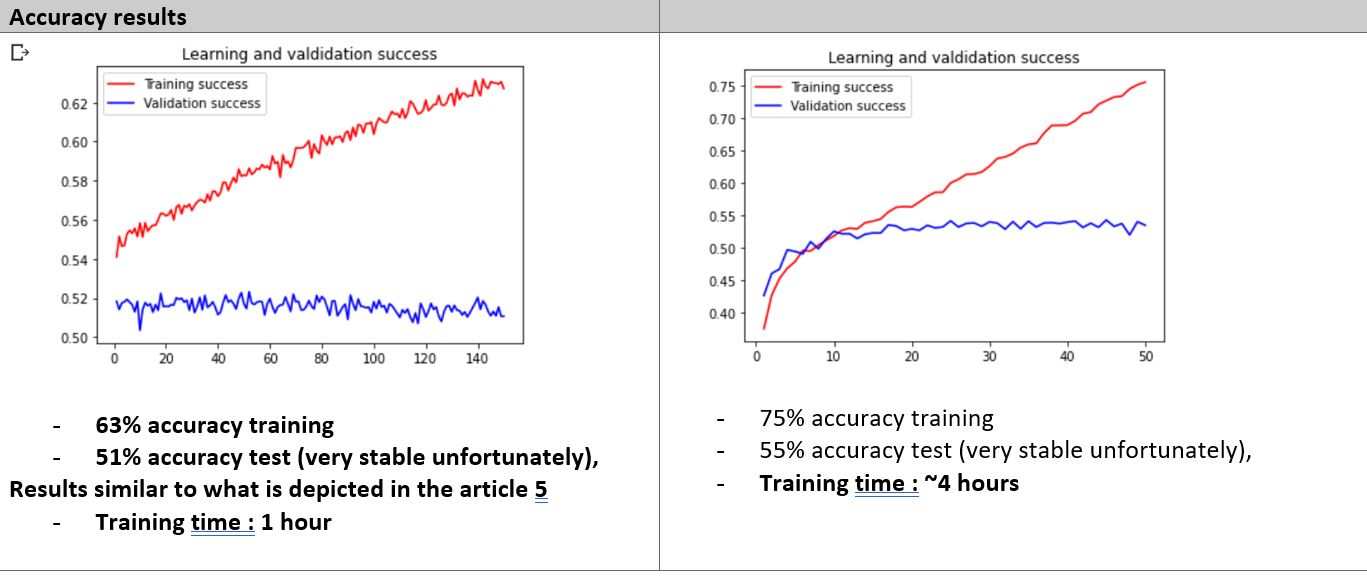


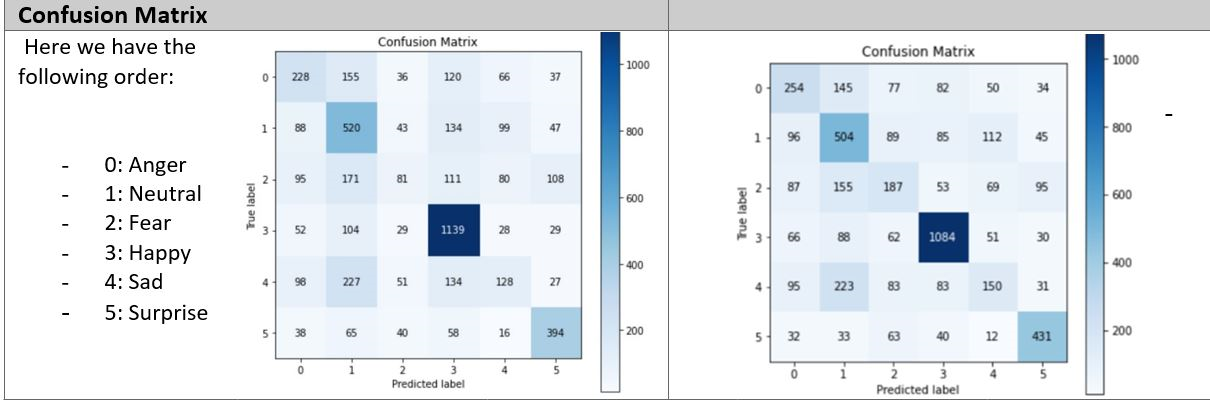

-	this new architecture has more depth that the previous one and extracts more features at each layer but has a more important time cost.
-	Test accuracy got better (by almost 5 points), but still reaches a ceiling value and can’t go higher.
-	Overfit 
-	Confusion matrix: the results are surprisingly similar between those two models. They interpret the emotions in the same way.  This new was able to discriminate the fear emotion better than the previous version.
-	The emotion that has the highest recognition rate is by far still happiness.
-	The emotions that are confused the most in the new model are:
--	(by far): neutral and sad
--	Neutral and fear
--	Anger and neutral.
-	Those results are interesting for several results:
o	The model has a hard time discriminating the neutral emotion, or rather the absence of emotion.
o	It is surely linked that when the face is neutral the mouth sometimes kind of points downwards.
o	The neutral face is confused the most with negative emotions.
o	What really is a neutral face? Is it really an absence of emotion or a mix of other emotions/states (boredom, concentration…)?
o	Would the accuracy of the model increase without the neutral label? This could be a great way to boost accuracy.
